In [147]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

import seaborn as sns
sns.set()
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/CS142 Network/dataset_SuperRare")
!ls /content/drive/MyDrive/'CS142 Network'/dataset_SuperRare

#on-colab Dataframe loading
sales_data = pd.read_csv("/content/drive/MyDrive/CS142 Network/dataset_SuperRare/sales.csv")
art_data = pd.read_csv("/content/drive/MyDrive/CS142 Network/dataset_SuperRare/tokens.csv")
bids_data = pd.read_csv("/content/drive/MyDrive/CS142 Network/dataset_SuperRare/bids.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 bids.csv      main.ipynb  'nft graph.ipynb'   sales.csv      tokens.csv
 bids.gsheet   my_util.py   __pycache__        sales.gsheet


# Sales network
## 1. General

DiGraph with 3052 nodes and 11326 edges
Transitivity: 0.03608764535683919
Is strongly connected? False. Number of components: 2662
Size of strongly connected components(with size > 1):
387 2 2 2 2 
Is weakly connected? False. Number of components: 34
Size of weakly connected components(with size > 1):
2983 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 

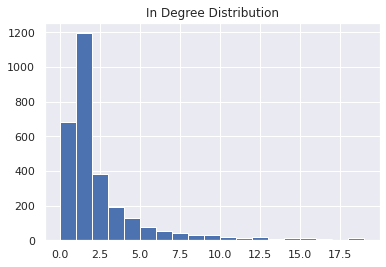

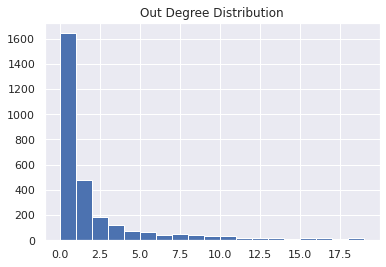

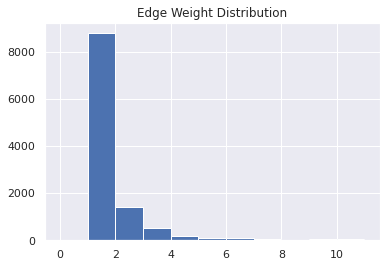

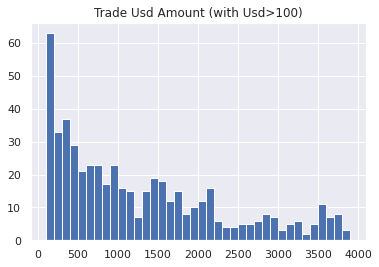

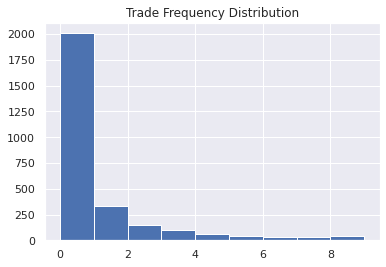

In [2]:
sales_graph = nx.DiGraph()

sales_graph.add_nodes_from(sales_data["buyer"], num_sell = 0, num_buy = 0, usd_sell = 0., usd_buy = 0.)
sales_graph.add_nodes_from(sales_data["seller"], num_sell = 0, num_buy = 0, usd_sell = 0., usd_buy = 0.)

for _, row in sales_data.iterrows():
  if row["seller"] in sales_graph.nodes and row["buyer"] in sales_graph.adj[row["seller"]]:
    the_Edge = sales_graph[row["seller"]][row["buyer"]]
    the_Edge['num'] += 1
    the_Edge['ID'].append(row["tokenId"])
    the_Edge['usd'].append(row["usd"])
    the_Edge['time'].append(row["timestamp"])
    sales_graph.nodes[row["buyer"]]['num_buy'] += 1
    sales_graph.nodes[row["seller"]]['num_sell'] += 1
    sales_graph.nodes[row["buyer"]]['usd_buy'] += float(row["usd"])
    sales_graph.nodes[row["seller"]]['usd_sell'] += float(row["usd"])
  else:
    sales_graph.add_edge(row["seller"], row["buyer"], num = 1, ID=[row["tokenId"]], usd=[float(row["usd"])], time=[row["timestamp"]])
        
print(sales_graph)

print("Transitivity: " + str(nx.transitivity(sales_graph)))
print("Is strongly connected? " + str(nx.is_strongly_connected(sales_graph)) + ". Number of components: " + str(nx.number_strongly_connected_components(sales_graph)))
print("Size of strongly connected components(with size > 1):")
for i in nx.strongly_connected_components(sales_graph):
  if len(i)>1:
    print(len(i), end=' ')
print()
print("Is weakly connected? " + str(nx.is_weakly_connected(sales_graph)) + ". Number of components: " + str(nx.number_weakly_connected_components(sales_graph)))
print("Size of weakly connected components(with size > 1):")
for i in nx.weakly_connected_components(sales_graph):
  if len(i)>1:
    print(len(i), end=' ')

in_Degrees = []
out_Degrees = []
for i in sales_graph.nodes:
    in_Degrees.append(sales_graph.in_degree[i])
    out_Degrees.append(sales_graph.out_degree[i])

plt.hist(in_Degrees, bins=range(20))
plt.title("In Degree Distribution")
plt.show()

plt.hist(out_Degrees, bins=range(20))
plt.title("Out Degree Distribution")
plt.show()

edge_Num = []
for e in sales_graph.edges:
    edge_Num.append(sales_graph[e[0]][e[1]]['num'])
plt.hist(edge_Num, bins=range(12))
plt.title("Edge Weight Distribution")
plt.show()

usds_total = []
num_total = []
for n in sales_graph.nodes:
    usds_total.append(float(sales_graph.nodes[n]['usd_buy']) + float(sales_graph.nodes[n]['usd_sell']))
    num_total.append(sales_graph.nodes[n]['num_buy'] + sales_graph.nodes[n]['num_sell'])

plt.hist(usds_total, bins = range(100, 4000, 100))
plt.title("Trade Usd Amount (with Usd>100)")
plt.show()
plt.hist(num_total, bins=range(10))
plt.title("Trade Frequency Distribution")
plt.show()


## 2. Biggest component

DiGraph with 387 nodes and 2741 edges


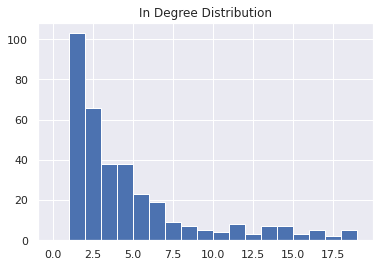

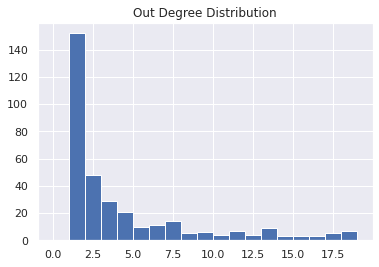

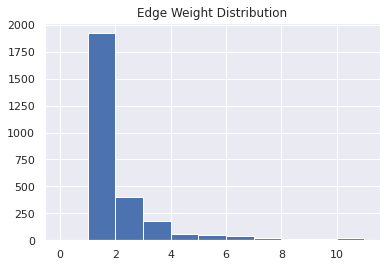

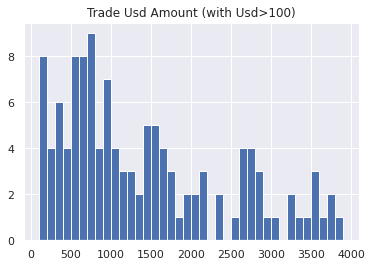

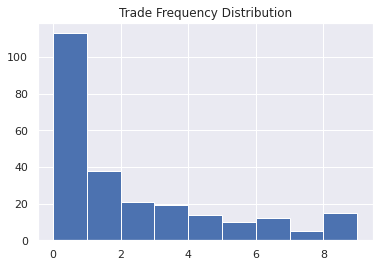

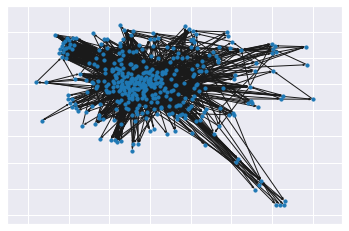

In [3]:
s_components = nx.strongly_connected_components(sales_graph)
s_components = sorted(s_components, key=len, reverse=True)
sales_component = sales_graph.subgraph(s_components[0])
print(sales_component)

c_in_Degrees = []
c_out_Degrees = []
for i in sales_component.nodes:
    c_in_Degrees.append(sales_component.in_degree[i])
    c_out_Degrees.append(sales_component.out_degree[i])


plt.hist(c_in_Degrees, bins=range(20))
plt.title("In Degree Distribution")
plt.show()

plt.hist(c_out_Degrees, bins=range(20))
plt.title("Out Degree Distribution")
plt.show()

c_edge_Num = []
for e in sales_component.edges:
    c_edge_Num.append(sales_component[e[0]][e[1]]['num'])
plt.hist(c_edge_Num, bins=range(12))
plt.title("Edge Weight Distribution")
plt.show()

c_usds_total = []
c_num_total = []
for n in sales_component.nodes:
    c_usds_total.append(float(sales_component.nodes[n]['usd_buy']) + float(sales_component.nodes[n]['usd_sell']))
    c_num_total.append(sales_component.nodes[n]['num_buy'] + sales_component.nodes[n]['num_sell'])

plt.hist(c_usds_total, bins = range(100, 4000, 100))
plt.title("Trade Usd Amount (with Usd>100)")
plt.show()
plt.hist(c_num_total, bins=range(10))
plt.title("Trade Frequency Distribution")
plt.show()

nx.draw_networkx(sales_component, pos=nx.spring_layout(sales_component), arrowsize=3, with_labels=False, node_size=10)

# Main

## Sorting and sampling data

In [148]:
import datetime

sales_data['timestamp']=pd.to_datetime(sales_data['timestamp'])
sales_data = sales_data.sort_values(by = 'timestamp')
sales_data = sales_data.reset_index(drop = True)
sales_data

,timestamp,tokenId,buyer,seller,eth,rate,usd,contract,transactionId
0,2018-04-05 23:50:12+00:00,1,0xbc74c3adc2aa6a85bda3eca5b0e235ca08532772,0x860c4604fe1125ea43f81e613e7afb2aa49546aa,0.4600,381.36,175.42560,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0xf1097e3617632e43b7c0a46ffeb4d741d0a67b25fb06...
1,2018-04-05 23:59:06+00:00,2,0xbc74c3adc2aa6a85bda3eca5b0e235ca08532772,0x860c4604fe1125ea43f81e613e7afb2aa49546aa,0.4600,381.36,175.42560,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0x9e9befc01fe11425ae8a2b903c8f8e1ec9777157d3e9...
2,2018-04-06 00:17:36+00:00,3,0xbc74c3adc2aa6a85bda3eca5b0e235ca08532772,0x860c4604fe1125ea43f81e613e7afb2aa49546aa,0.4600,370.35,170.36100,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0x66e9ac3a5d651123398f274ffecfccbbb86f04748c70...
3,2018-04-06 02:24:16+00:00,4,0xbc74c3adc2aa6a85bda3eca5b0e235ca08532772,0x860c4604fe1125ea43f81e613e7afb2aa49546aa,0.4600,370.35,170.36100,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0x0f4efbc5a8350e36e8ed03225f643b32544254add8c6...
4,2018-04-14 17:31:58+00:00,17,0x337101def3eeb6f06e071efe02216274507937bb,0x21316e6a4f0af45e5f1503984e83b10c53b177d8,0.4230,502.79,212.68017,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0x6c01b80f7f8abf7e7668cda5178fbe45c5901f5c8dae...
...,...,...,...,...,...,...,...,...,...
17524,2021-03-26 13:54:05+00:00,22230,0x3eb18413d536d7ab03320300598de457fa078ab2,0xca49240330b460a7f804854c58921219df6f47c8,2.1000,NaN,NaN,0xb932a70a57673d89f4acffbe830e8ed7f75fb9e0,0x42599375ab5e81757432ea2b18c248d122d404fdba78...
17525,2021-03-26 14:11:25+00:00,9625,0x4e7b8d5dfbef53faca35bbb2400785e93a6ef5aa,0x884232cdb27f593cd8a7b7cfe8f6785d85fc9fc5,1.2500,NaN,NaN,0xb932a70a57673d89f4acffbe830e8ed7f75fb9e0,0xd2b1eafc866b3db5710d3b7ea5f30bd84d54713a1a6b...
17526,2021-03-26 15:08:31+00:00,887,0x68b498a5ebcd1f649a7ae3f4f42d33fe067fb483,0xa353401738e7ec6a4db9c0ee4c66eb5252f681c4,2.9900,NaN,NaN,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0x2cac0258142b7fd602e1042b93ea696e706681025be6...
17527,2021-03-26 15:19:41+00:00,6136,0x8f903cfc0af3c2ec0d872c57538af5e071544a57,0x2c775bcdaaf5ebebe73313f50671c6e09f05f824,0.4200,NaN,NaN,0xb932a70a57673d89f4acffbe830e8ed7f75fb9e0,0x0e211126fe945285a7781a72a8df54fa2ff8059050c6...


In [112]:
#Ts = range(0, 18000, 1000)


#t_data3 = sales_data[:12000]
#t_data4 = sales_data[:15000]


### Testing & Training data setup

In [153]:
ansses = []
for t in range(1,35):
    anss = []
    for i in range(40):
        for j in range(i+1, 40):
            t_anss = []
            t_anss.append(sales_data['tokenId'][i + t*500 - 40])
            t_anss.append(sales_data['tokenId'][j + t*500 - 40])
            if float(sales_data['usd'][t*500 - 40 + i]) > float(sales_data['usd'][ t*500 - 40 + j]):
                t_anss.append("1")
            else:
                t_anss.append("0")
            anss.append(t_anss)
    ansses.append(anss)
#'tokenId'
ansses[0]

[[1306, 1350, '0'],
 [1306, 1305, '0'],
 [1306, 1345, '0'],
 [1306, 1357, '0'],
 [1306, 1107, '0'],
 [1306, 1247, '0'],
 [1306, 1304, '0'],
 [1306, 1316, '0'],
 [1306, 1280, '1'],
 [1306, 99, '1'],
 [1306, 1336, '0'],
 [1306, 1340, '0'],
 [1306, 1334, '0'],
 [1306, 502, '1'],
 [1306, 62, '0'],
 [1306, 1339, '0'],
 [1306, 1308, '0'],
 [1306, 677, '0'],
 [1306, 710, '0'],
 [1306, 1068, '0'],
 [1306, 1030, '0'],
 [1306, 1232, '0'],
 [1306, 114, '0'],
 [1306, 116, '0'],
 [1306, 734, '1'],
 [1306, 1045, '0'],
 [1306, 932, '0'],
 [1306, 812, '1'],
 [1306, 499, '1'],
 [1306, 1299, '0'],
 [1306, 59, '0'],
 [1306, 49, '0'],
 [1306, 126, '1'],
 [1306, 90, '1'],
 [1306, 517, '1'],
 [1306, 1318, '0'],
 [1306, 568, '0'],
 [1306, 1351, '0'],
 [1306, 1287, '0'],
 [1350, 1305, '1'],
 [1350, 1345, '0'],
 [1350, 1357, '1'],
 [1350, 1107, '1'],
 [1350, 1247, '0'],
 [1350, 1304, '1'],
 [1350, 1316, '1'],
 [1350, 1280, '1'],
 [1350, 99, '1'],
 [1350, 1336, '0'],
 [1350, 1340, '0'],
 [1350, 1334, '0'],
 [13

## Transaction network set up

In [7]:
!pip install --upgrade scipy
!pip install 'networkx<2.7'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [154]:
Gs = []
NFT_owners = []
hs = []
aas = []
indes = []
outdes = []
prs = []
clcs = []

for t in range(1,35):
    G = nx.DiGraph()
    NFT_owner = {}
    G.add_nodes_from(sales_data[:t*500]["buyer"], num_sell = 0, num_buy = 0, usd_sell = 0., usd_buy = 0.)
    G.add_nodes_from(sales_data[:t*500]["seller"], num_sell = 0, num_buy = 0, usd_sell = 0., usd_buy = 0.)
    for _, row in sales_data[:t*500].iterrows():
        #print(row["tokenId"])
        NFT_owner[row["tokenId"]] = row["buyer"]
        if row["seller"] in G.nodes and row["buyer"] in G.adj[row["seller"]]:
            the_Edge = G[row["seller"]][row["buyer"]]
            the_Edge['num'] += 1
            the_Edge['ID'].append(row["tokenId"])
            the_Edge['usd'].append(row["usd"])
            the_Edge['time'].append(row["timestamp"])
            G.nodes[row["buyer"]]['num_buy'] += 1
            G.nodes[row["seller"]]['num_sell'] += 1
            G.nodes[row["buyer"]]['usd_buy'] += float(row["usd"])
            G.nodes[row["seller"]]['usd_sell'] += float(row["usd"])
        else:
            G.add_edge(row["seller"], row["buyer"], weight = float(row["usd"]), num = 1, ID=[row["tokenId"]], usd=[float(row["usd"])], time=[row["timestamp"]])
    print(G)
    Gs.append(G)
    NFT_owners.append(NFT_owner)
    h, a = nx.hits(G)
    hs.append(h)
    aas.append(a)
    inde = G.in_degree(weight='weight')
    indes.append(inde)
    outde = G.out_degree(weight = 'weight')
    outdes.append(outde)
    pr = nx.pagerank(G, weight = 'weight')
    prs.append(pr)
    clc = nx.closeness_centrality(G, distance = 'weight')
    clcs.append(clc)

DiGraph with 141 nodes and 330 edges
DiGraph with 198 nodes and 566 edges
DiGraph with 263 nodes and 818 edges
DiGraph with 354 nodes and 1166 edges
DiGraph with 385 nodes and 1403 edges
DiGraph with 416 nodes and 1670 edges
DiGraph with 453 nodes and 1932 edges
DiGraph with 489 nodes and 2172 edges
DiGraph with 555 nodes and 2469 edges
DiGraph with 618 nodes and 2760 edges
DiGraph with 660 nodes and 3022 edges
DiGraph with 710 nodes and 3305 edges
DiGraph with 748 nodes and 3570 edges
DiGraph with 800 nodes and 3843 edges
DiGraph with 844 nodes and 4088 edges
DiGraph with 901 nodes and 4366 edges
DiGraph with 975 nodes and 4649 edges
DiGraph with 1034 nodes and 4908 edges
DiGraph with 1115 nodes and 5224 edges
DiGraph with 1220 nodes and 5584 edges
DiGraph with 1318 nodes and 5935 edges
DiGraph with 1421 nodes and 6312 edges
DiGraph with 1513 nodes and 6690 edges
DiGraph with 1598 nodes and 7022 edges
DiGraph with 1701 nodes and 7351 edges
DiGraph with 1820 nodes and 7722 edges
DiGrap

In [155]:
hits_hub_ans = []

for t in range(1,35):
    count = 0
    acc = 0
    for i in ansses[t-1]:
        count += 1
        #print(NFT_owner[i[0]])
        m = hs[t-1][str(NFT_owners[t-1][int(i[0])])] + hs[t-1][str(NFT_owners[t-1][int(i[0])])]
        n = hs[t-1][str(NFT_owners[t-1][int(i[1])])] + hs[t-1][str(NFT_owners[t-1][int(i[1])])]
        if (m>n and i[2] == "1") or  (m<n and i[2] == "0"):
            acc += 1
    hits_hub_ans.append(acc/count)

print("HITS-hub: ")
print(hits_hub_ans)


HITS-hub: 
[0.03333333333333333, 0.2782051282051282, 0.1641025641025641, 0.34102564102564104, 0.16538461538461538, 0.16538461538461538, 0.3076923076923077, 0.4064102564102564, 0.17435897435897435, 0.12051282051282051, 0.2846153846153846, 0.17564102564102563, 0.43846153846153846, 0.4012820512820513, 0.23846153846153847, 0.3038461538461538, 0.18846153846153846, 0.30641025641025643, 0.27692307692307694, 0.3858974358974359, 0.36923076923076925, 0.15, 0.2794871794871795, 0.2833333333333333, 0.22564102564102564, 0.2012820512820513, 0.11794871794871795, 0.14487179487179488, 0.06282051282051282, 0.22179487179487178, 0.16282051282051282, 0.4371794871794872, 0.16794871794871793, 0.21923076923076923]


In [156]:
hits_auth_ans = []

for t in range(1,35):
    count = 0
    acc = 0
    for i in ansses[t-1]:
        count += 1
        #print(NFT_owner[i[0]])
        m = aas[t-1][str(NFT_owners[t-1][int(i[0])])] + aas[t-1][str(NFT_owners[t-1][int(i[0])])]
        n = aas[t-1][str(NFT_owners[t-1][int(i[1])])] + aas[t-1][str(NFT_owners[t-1][int(i[1])])]
        if (m>n and i[2] == "1") or  (m<n and i[2] == "0"):
            acc += 1
    hits_auth_ans.append(acc/count)

print("HITS-auth: ")
print(hits_auth_ans)




HITS-auth: 
[0.07051282051282051, 0.30256410256410254, 0.5397435897435897, 0.5794871794871795, 0.6820512820512821, 0.5628205128205128, 0.6012820512820513, 0.6230769230769231, 0.5897435897435898, 0.6294871794871795, 0.6038461538461538, 0.36153846153846153, 0.5679487179487179, 0.6294871794871795, 0.4, 0.5641025641025641, 0.7448717948717949, 0.6423076923076924, 0.6294871794871795, 0.7435897435897436, 0.5833333333333334, 0.6717948717948717, 0.5551282051282052, 0.7025641025641025, 0.382051282051282, 0.41025641025641024, 0.65, 0.6884615384615385, 0.5820512820512821, 0.6141025641025641, 0.5820512820512821, 0.6833333333333333, 0.6743589743589744, 0.6089743589743589]


In [157]:
hits_ans = []

for t in range(1,35):
    count = 0
    acc = 0
    for i in ansses[t-1]:
        count += 1
        #print(NFT_owner[i[0]])
        m = hs[t-1][str(NFT_owners[t-1][int(i[0])])] + aas[t-1][str(NFT_owners[t-1][int(i[0])])]
        n = hs[t-1][str(NFT_owners[t-1][int(i[1])])] + aas[t-1][str(NFT_owners[t-1][int(i[1])])]
        if (m>n and i[2] == "1") or  (m<n and i[2] == "0"):
            acc += 1
    hits_ans.append(acc/count)

print("HITS: ")
print(hits_ans)

HITS: 
[0.07051282051282051, 0.3038461538461538, 0.45897435897435895, 0.5435897435897435, 0.6538461538461539, 0.5256410256410257, 0.6294871794871795, 0.6128205128205129, 0.591025641025641, 0.6141025641025641, 0.5756410256410256, 0.3435897435897436, 0.5641025641025641, 0.6217948717948718, 0.39615384615384613, 0.5487179487179488, 0.6705128205128205, 0.5884615384615385, 0.6128205128205129, 0.7256410256410256, 0.5692307692307692, 0.6576923076923077, 0.5461538461538461, 0.6282051282051282, 0.4371794871794872, 0.3935897435897436, 0.6448717948717949, 0.6666666666666666, 0.5794871794871795, 0.6089743589743589, 0.5564102564102564, 0.6897435897435897, 0.6653846153846154, 0.5987179487179487]


In [158]:
random_ans = []

for t in range(1,35):
    count = 0
    acc = 0
    for i in ansses[t-1]:
        count += 1
        m = 1
        if int(np.random.rand() * 1000)%2==0:
            n = 2
        else:
            n = 0
        if (m>n and i[2] == "1") or  (m<n and i[2] == "0"):
            acc += 1
    random_ans.append(acc/count)

print("random: ")
print(random_ans)

random: 
[0.4653846153846154, 0.5217948717948718, 0.49743589743589745, 0.5064102564102564, 0.4987179487179487, 0.5064102564102564, 0.4858974358974359, 0.5025641025641026, 0.4948717948717949, 0.5307692307692308, 0.4987179487179487, 0.5012820512820513, 0.4987179487179487, 0.49615384615384617, 0.4794871794871795, 0.5128205128205128, 0.4948717948717949, 0.5243589743589744, 0.4846153846153846, 0.5102564102564102, 0.491025641025641, 0.4705128205128205, 0.4935897435897436, 0.5384615384615384, 0.4935897435897436, 0.4987179487179487, 0.4666666666666667, 0.5461538461538461, 0.49230769230769234, 0.5102564102564102, 0.49615384615384617, 0.5230769230769231, 0.5051282051282051, 0.4948717948717949]


In [159]:
degree_ans = []

for t in range(1,35):
    count = 0
    acc = 0
    for i in ansses[t-1]:
        count += 1
        #print(NFT_owner[i[0]])
        m = indes[t-1][str(NFT_owners[t-1][int(i[0])])] + outdes[t-1][str(NFT_owners[t-1][int(i[0])])]
        n = indes[t-1][str(NFT_owners[t-1][int(i[1])])] + outdes[t-1][str(NFT_owners[t-1][int(i[1])])]
        if (m>n and i[2] == "1") or  (m<n and i[2] == "0"):
            acc += 1
    degree_ans.append(acc/count)

print("degrees: ")
print(degree_ans)


degrees: 
[0.07179487179487179, 0.3230769230769231, 0.4512820512820513, 0.45384615384615384, 0.6602564102564102, 0.5371794871794872, 0.6487179487179487, 0.632051282051282, 0.6794871794871795, 0.6692307692307692, 0.6333333333333333, 0.35128205128205126, 0.6128205128205129, 0.6576923076923077, 0.3384615384615385, 0.5333333333333333, 0.6410256410256411, 0.5948717948717949, 0.6525641025641026, 0.7461538461538462, 0.5782051282051283, 0.7076923076923077, 0.5884615384615385, 0.6115384615384616, 0.7423076923076923, 0.7230769230769231, 0.7525641025641026, 0.5833333333333334, 0.5948717948717949, 0.658974358974359, 0.5871794871794872, 0.7102564102564103, 0.6692307692307692, 0.6717948717948717]


In [160]:
pr_ans = []

for t in range(1,35):
    count = 0
    acc = 0
    for i in ansses[t-1]:
        count += 1
        #print(NFT_owner[i[0]])
        m = prs[t-1][str(NFT_owners[t-1][int(i[0])])] + prs[t-1][str(NFT_owners[t-1][int(i[0])])]
        n = prs[t-1][str(NFT_owners[t-1][int(i[1])])] + prs[t-1][str(NFT_owners[t-1][int(i[1])])]
        if (m>n and i[2] == "1") or  (m<n and i[2] == "0"):
            acc += 1
    pr_ans.append(acc/count)

print("pagerank: ")
print(pr_ans)


pagerank: 
[0.05512820512820513, 0.35128205128205126, 0.5217948717948718, 0.4256410256410256, 0.6423076923076924, 0.5858974358974359, 0.6205128205128205, 0.6217948717948718, 0.7397435897435898, 0.6243589743589744, 0.6512820512820513, 0.3435897435897436, 0.5807692307692308, 0.5628205128205128, 0.2833333333333333, 0.5525641025641026, 0.6243589743589744, 0.5923076923076923, 0.6282051282051282, 0.7012820512820512, 0.5717948717948718, 0.6897435897435897, 0.5717948717948718, 0.5717948717948718, 0.735897435897436, 0.6397435897435897, 0.6846153846153846, 0.55, 0.6064102564102564, 0.5897435897435898, 0.5064102564102564, 0.6192307692307693, 0.5435897435897435, 0.5564102564102564]


In [161]:
clc_ans = []

for t in range(1,35):
    count = 0
    acc = 0
    for i in ansses[t-1]:
        count += 1
        #print(NFT_owner[i[0]])
        m = clcs[t-1][str(NFT_owners[t-1][int(i[0])])] + clcs[t-1][str(NFT_owners[t-1][int(i[0])])]
        n = clcs[t-1][str(NFT_owners[t-1][int(i[1])])] + clcs[t-1][str(NFT_owners[t-1][int(i[1])])]
        if (m>n and i[2] == "1") or  (m<n and i[2] == "0"):
            acc += 1
    clc_ans.append(acc/count)

print("closeness centrality: ")
print(clc_ans)


closeness centrality: 
[0.07051282051282051, 0.35512820512820514, 0.33205128205128204, 0.3782051282051282, 0.4358974358974359, 0.28974358974358977, 0.3782051282051282, 0.44743589743589746, 0.39871794871794874, 0.4166666666666667, 0.5153846153846153, 0.21923076923076923, 0.19743589743589743, 0.48205128205128206, 0.24358974358974358, 0.5, 0.45, 0.5064102564102564, 0.38461538461538464, 0.4551282051282051, 0.48333333333333334, 0.4666666666666667, 0.41923076923076924, 0.5153846153846153, 0.532051282051282, 0.5743589743589743, 0.3717948717948718, 0.3423076923076923, 0.31025641025641026, 0.4076923076923077, 0.33076923076923076, 0.4666666666666667, 0.44487179487179485, 0.3871794871794872]


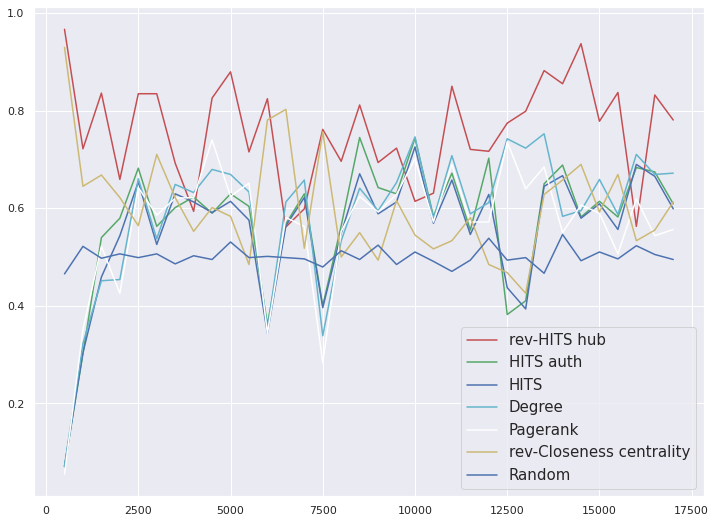

In [172]:
Ts = range(500, 17500, 500)
rhits_hub_ans = []
rclc_ans = []
for i in hits_hub_ans:
  rhits_hub_ans.append(1-i)

for i in clc_ans:
  rclc_ans.append(1-i)

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(9)

plt.plot(Ts, rhits_hub_ans, color='r')
plt.plot(Ts, hits_auth_ans, color='g')
plt.plot(Ts, hits_ans, color='b')
plt.plot(Ts, degree_ans, color='c')
plt.plot(Ts, pr_ans, color='w')
plt.plot(Ts, rclc_ans, color='y')
plt.plot(Ts, random_ans)
plt.legend(["rev-HITS hub", "HITS auth", "HITS", "Degree", "Pagerank", "rev-Closeness centrality", "Random"], prop={'size':15})


In [173]:
print("rev-HITS hub:" + str(np.mean(rhits_hub_ans)))
print("HITS auth:" + str(np.mean(hits_auth_ans)))
print("HITS:" + str(np.mean(hits_ans)))
print("Degree:" + str(np.mean(degree_ans)))
print("Pagerank:" + str(np.mean(pr_ans)))
print("rev-Closeness centrality:" + str(np.mean(rclc_ans)))

rev-HITS hub:0.7588235294117647
HITS auth:0.5722473604826546
HITS:0.5556938159879335
Degree:0.5902337858220212
Pagerank:0.5631221719457014
rev-Closeness centrality:0.6026772247360483


## NFT network set up

In [11]:
G2 = nx.DiGraph()

# add edges
for i in range(len(sales_data[:1990]) - 1):
    if np.isnan(sales_data["usd"][i]):
        break
    
    curr = i + 1
    while (sales_data["timestamp"][curr] - sales_data['timestamp'][i]).days < 30:
        if (sales_data["tokenId"][i] != sales_data["tokenId"][curr]) and (not np.isnan(sales_data["usd"][curr])):
            if (sales_data["usd"][i] > sales_data["usd"][curr]):
                G2.add_edge(sales_data["tokenId"][i], sales_data["tokenId"][curr], weight = 70 - curr/30)
            elif (sales_data["usd"][i] < sales_data["usd"][curr]):
                G2.add_edge(sales_data["tokenId"][curr], sales_data["tokenId"][i], weight = 70 - curr/30)
        curr += 1

print(G2)

DiGraph with 2124 nodes and 307746 edges


In [12]:
sales_data["tokenId"][i]


4876

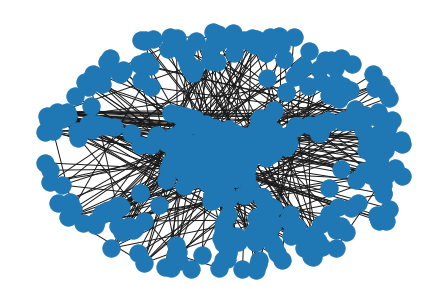

In [16]:
T=nx.minimum_spanning_tree(G2.to_undirected())
nx.draw(T)
